In [2]:
import pandas as pd
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [59]:
df = pd.read_csv('kuzushiji_resized/traincsv.csv')

In [60]:
df

,image_id,labels
0,100241706_00004_2,U+306F 586.824459234609 1728.922302529685 66.3...
1,100241706_00005_1,U+306F 520.7784280936455 1006.916365513681 51....
2,100241706_00005_2,U+306F 271.3211920529801 686.5792462570986 62....
3,100241706_00006_1,U+3082 705.9398814563929 1496.7568193515183 32...
4,100241706_00007_2,U+309D 575.3954849498328 1473.7375904860394 13...
...,...,...
3600,umgy012-038,U+30FD 582.3062645011602 526.0948453608247 15....
3601,umgy012-039,U+309D 271.0694058856191 301.65913757700207 19...
3602,umgy012-040,U+30DE 441.0699260943718 216.91523678792038 45...
3603,umgy012-041,U+309D 982.640650406504 526.942895989123 10.51...


In [61]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

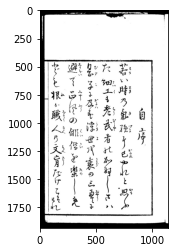

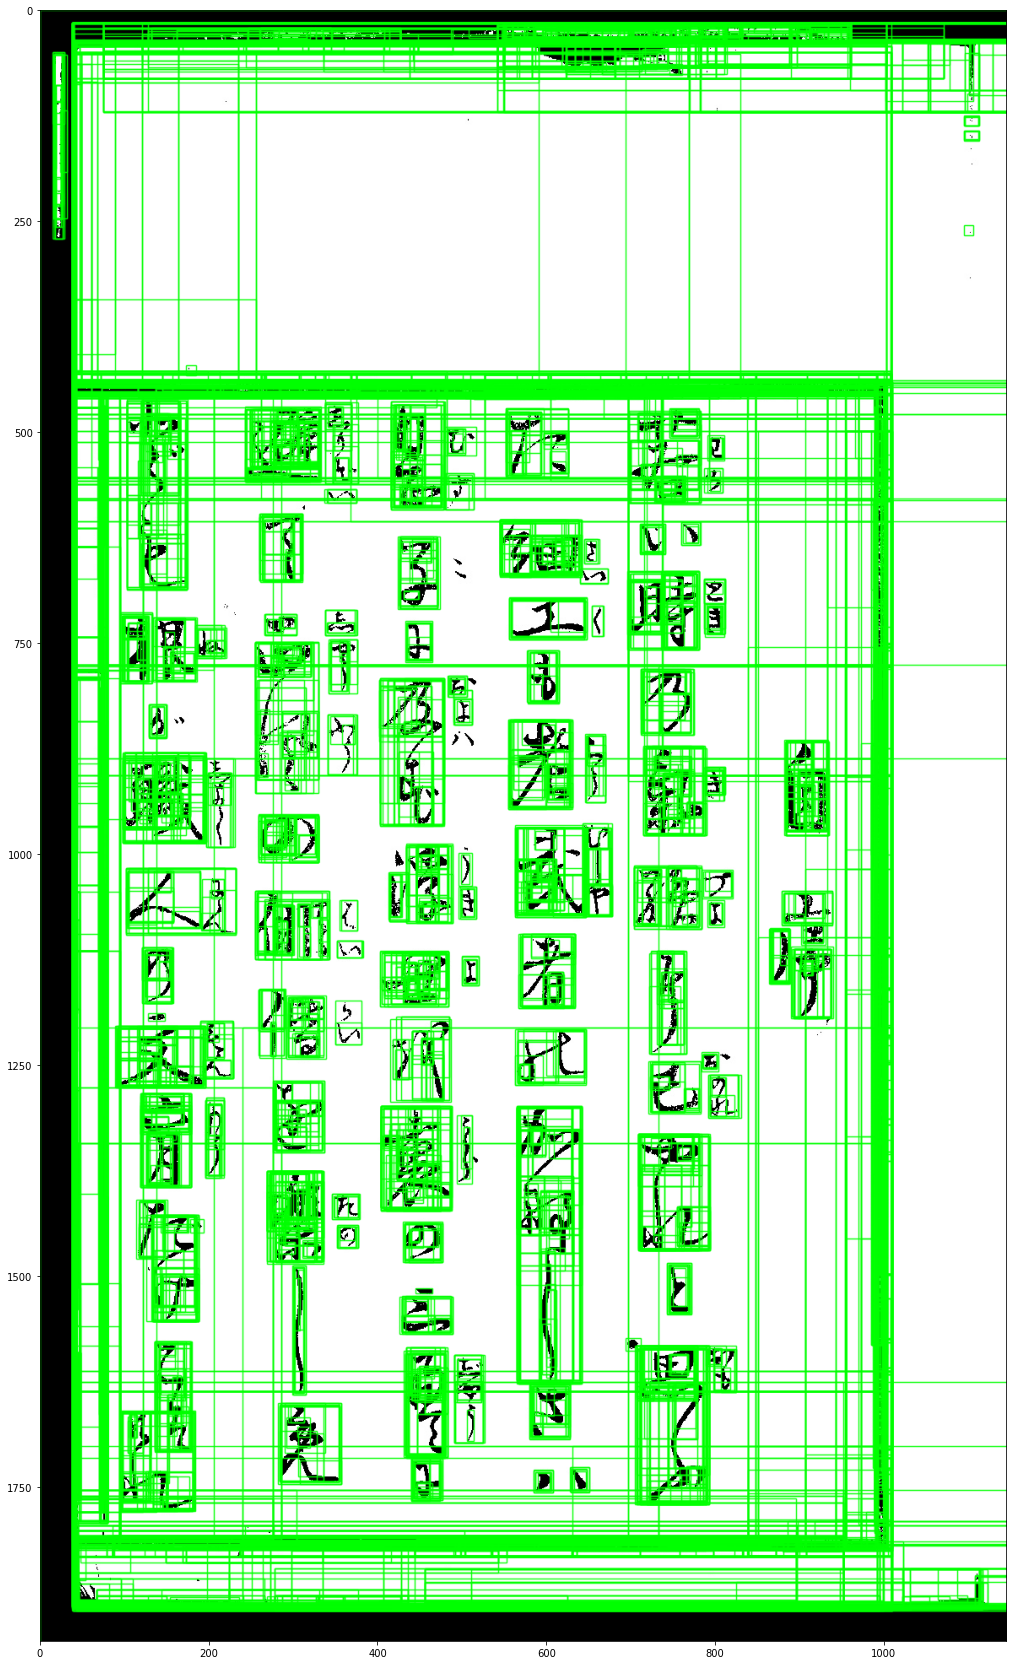

In [62]:
for index, row in df.iterrows():
    image_id = row[0]
    labels = row[1]

    filename = 'kuzushiji_resized/train_images/'+image_id+'.jpg'
    img = cv2.imread(filename)
    plt.imshow(img)

    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imOut = img.copy()
    for i, rect in (enumerate(rects)):
        x, y, w, h = rect
    #     print(x,y,w,h)
    #     imOut = imOut[x:x+w,y:y+h]
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    # plt.figure()
    plt.figure(figsize=(30,30))
    plt.imshow(imOut)
    break

In [63]:
len(rects)

4577

In [67]:
def get_iou(bb1, bb2):
#     print(bb1)
#     print(bb2)
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
#         print("ovde")
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
#     print(iou)
    return iou

In [65]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [97]:
train_images=[]
train_labels=[]
for index, row in df[:200].iterrows():
    try:
        image_id = row[0]
        labels = row[1]
        filename = 'kuzushiji_resized/train_images/'+image_id+'.jpg'
        print(index, filename)
        image = cv2.imread(filename)
        
        ls = labels.split(' ')
        index = len(ls) - 1
        ls1 = ls[:index]
        labels1 = np.array(ls1).reshape(-1, 5)
        gtvalues=[]
        for codepoint, x1, y1, w1, h1 in labels1:
            x1, y1, w1, h1 = float(x1), float(y1), float(w1), float(h1)
#             char = unicode_map[codepoint]
            x2 = x1 + w1
            y2 = y1 + h1
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        
#         print(gtvalues)
        
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
#         print(len(ssresults))
        for e, result in enumerate(ssresults):
#             if e < 2000 and flag == 0:
            if flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
#                     print(iou)
                    if counter < 30:
                        if iou > 0.70:
                            print("nasao")
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (100,100), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (100,100), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue
#     break

0 kuzushiji_resized/train_images/100241706_00004_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
1 kuzushiji_resized/train_images/100241706_00005_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
2 kuzushiji_resized/train_images/100241706_00005_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
3 kuzushiji_resized/train_images/100241706_00006_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
4 kuzushiji_resized/train_images

nasao
nasao
nasao
nasao
nasao
inside
34 kuzushiji_resized/train_images/100241706_00022_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
35 kuzushiji_resized/train_images/100241706_00023_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
36 kuzushiji_resized/train_images/100241706_00023_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
37 kuzushiji_resized/train_images/100241706_00024_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasa

nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
68 kuzushiji_resized/train_images/100249371_00003_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
69 kuzushiji_resized/train_images/100249371_00004_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
70 kuzushiji_resized/train_images/100249371_00005_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
71 kuzushiji_resized/train_images/100249371_00005_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasa

nasao
nasao
nasao
nasao
inside
102 kuzushiji_resized/train_images/100249371_00022_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
103 kuzushiji_resized/train_images/100249371_00022_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
104 kuzushiji_resized/train_images/100249371_00023_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
105 kuzushiji_resized/train_images/100249371_00023_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao


nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
136 kuzushiji_resized/train_images/100249376_00007_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
137 kuzushiji_resized/train_images/100249376_00008_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
138 kuzushiji_resized/train_images/100249376_00008_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
139 kuzushiji_resized/train_images/100249376_00009_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao


nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
170 kuzushiji_resized/train_images/100249376_00024_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
171 kuzushiji_resized/train_images/100249376_00025_1.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
172 kuzushiji_resized/train_images/100249376_00025_2.jpg
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
nasao
inside
173 kuzushiji_resized/train_images/100249376_00026_1.jpg
nasao
nasao
nasao
nasao


In [98]:
len(train_images)

12000

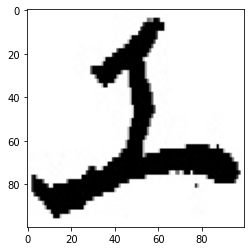

In [100]:
im1 = train_images[50]
plt.imshow(im1)

In [101]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [102]:
X_new.shape

(12000, 100, 100, 3)

In [103]:
y_new.shape

(12000,)

In [104]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn import metrics

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv3D, BatchNormalization, MaxPool2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint
from datetime import datetime

from keras import backend as K

In [105]:
leinst = LabelEncoder()
yyinst = leinst.fit_transform(y_new)

x_train, x_test, y_train, y_test = train_test_split(X_new, yyinst, test_size=0.2, shuffle=True, random_state=42)

x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=42)


print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)


num_classes = len(leinst.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_validation = to_categorical(y_validation, num_classes=num_classes)

(9600, 100, 100, 3)
(1200, 100, 100, 3)
(1200, 100, 100, 3)


In [106]:
num_classes

2

In [111]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(100,100,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

In [112]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [113]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization_20 (Bat  (None, 23, 23, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 11, 11, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 256)       614656    
                                                                 
 batch_normalization_21 (Bat  (None, 11, 11, 256)      1024      
 chNormalization)                                                
                                                      

In [114]:
num_epochs = 60
batch_size = 32

checkpointer = ModelCheckpoint(filepath="best_weights_rcnn.hdf5", verbose=1, save_best_only=True)

start = datetime.now()
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_validation, y_validation), 
           callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/60
300/300 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.7296
Epoch 1: val_loss improved from inf to 7.03107, saving model to best_weights_rcnn.hdf5
300/300 [==============================] - 239s 794ms/step - loss: 1.0237 - accuracy: 0.7296 - val_loss: 7.0311 - val_accuracy: 0.5758
Epoch 2/60
300/300 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.8855
Epoch 2: val_loss improved from 7.03107 to 0.25732, saving model to best_weights_rcnn.hdf5
300/300 [==============================] - 236s 787ms/step - loss: 0.6233 - accuracy: 0.8855 - val_loss: 0.2573 - val_accuracy: 0.9150
Epoch 3/60
300/300 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9447
Epoch 3: val_loss did not improve from 0.25732
300/300 [==============================] - 236s 788ms/step - loss: 0.2251 - accuracy: 0.9447 - val_loss: 0.5118 - val_accuracy: 0.8967
Epoch 4/60
300/300 [==============================] - ETA: 0s - loss: 0.3224 - acc

KeyboardInterrupt: 

In [115]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

300/300 [==============================] - 42s 140ms/step - loss: 0.0246 - accuracy: 0.9920
Training Accuracy:  0.99197918176651


In [116]:
test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

38/38 [==============================] - 5s 132ms/step - loss: 0.0655 - accuracy: 0.9833
Test Accuracy:  0.9833333492279053
